In [102]:
#!pip install clickhouse-driver

In [120]:
from clickhouse_driver import Client
from time import perf_counter
import pandas as pd
import matplotlib.pyplot as plt

1. Подключение к базе clickhouse и проверка работы соединения

In [121]:
client = Client('ip',
                user='user',
                port = 9001,
                password='passsowrd',
                secure=False,
                verify=False,
                database='database')
result = client.execute('select count(*) from database.mdl_logstore_standard_log;')
print(result)

[(62201362,)]


Все работает, идем дальше.

2. Количество уникальных ip-адресов за сутки и за неделю, также выведем адреса, которые заходили за последнюю минуту чаще, чем 10 раз (подозренее на DDOS)

In [105]:
start_time = perf_counter()
result = client.execute('SELECT count(distinct ip) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfDay(now())')
print(f"Число ip за сегодня - {result[0][0]}")
result = client.execute('SELECT count(distinct ip) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfWeek(now())')
print(f"Число ip за неделю - {result[0][0]}")
result = client.execute('SELECT * from (SELECT ip, count(*) as cnt FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfFiveMinutes(now()) group by ip) where cnt>100')
print(f"Подозрение на DDOS - {len(result)}")
for ip, count_ip in result:
    print("\t" + f"{ip} - {count_ip}")
print(f"Время выполнение {perf_counter()-start_time} сек")

Число ip за сегодня - 453
Число ip за неделю - 1098
Подозрение на DDOS - 0
Время выполнение 2.547540500003379 сек


3. Количество уникальных посетителей за сутки и за неделю

In [106]:
start_time = perf_counter()
result = client.execute('SELECT count(distinct userid) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfDay(now())')
print(f"Число уникальных посетителей сегодня за сегодня - {result[0][0]}")
result = client.execute('SELECT count(distinct userid) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfWeek(now())')
print(f"Число уникальных посетителей за неделю - {result[0][0]}")
print(f"Время выполнение {perf_counter()-start_time} сек")

Число уникальных посетителей сегодня за сегодня - 462
Число уникальных посетителей за неделю - 962
Время выполнение 0.47527009999612346 сек


4. Количество активных курсов за день и неделю, также выводим id самых активных курсов за неделю (нужны для отчетности)

In [107]:
start_time = perf_counter()
result = client.execute('SELECT count(distinct courseid) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfDay(now())')
print(f"Число активных курсов за сегодня - {result[0][0]}")
result = client.execute('SELECT count(distinct courseid) FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfWeek(now())')
print(f"Число активных курсов за неделю - {result[0][0]}")
result = client.execute('SELECT courseid, count(*) as cnt FROM database.mdl_logstore_standard_log where FROM_UNIXTIME(timecreated)>toStartOfWeek(now()) group by courseid order by cnt desc limit 10')
print(f"Самые популярные курсы за неделю - {len(result)}")
for id, count_id in result:
    print("\t" + f"{id} - {count_id}")
print(f"Время выполнение {perf_counter()-start_time} сек")


Число активных курсов за сегодня - 2222
Число активных курсов за неделю - 3847
Самые популярные курсы за неделю - 10
	0 - 4666
	13330 - 4021
	9475 - 3983
	9499 - 2189
	19287 - 1454
	9683 - 1009
	19788 - 611
	9550 - 606
	18734 - 572
	20508 - 481
Время выполнение 0.7099160999932792 сек


5. Проверка и анализ посещаемости, поиск периодичности (за последние 3 дня)

Активность пользователей за последние 3 дня
13 ч. 25 д. - 124940
14 ч. 25 д. - 318440
15 ч. 25 д. - 379150
16 ч. 25 д. - 453640
17 ч. 25 д. - 452720
18 ч. 25 д. - 425810
19 ч. 25 д. - 436930
20 ч. 25 д. - 413860
21 ч. 25 д. - 446590
22 ч. 25 д. - 424710
23 ч. 25 д. - 355670
0 ч. 26 д. - 248020
1 ч. 26 д. - 146120
2 ч. 26 д. - 135780
3 ч. 26 д. - 53150
4 ч. 26 д. - 29120
5 ч. 26 д. - 47460
6 ч. 26 д. - 91150
7 ч. 26 д. - 216790
8 ч. 26 д. - 623230
9 ч. 26 д. - 914150
10 ч. 26 д. - 1068040
11 ч. 26 д. - 1089140
12 ч. 26 д. - 1054970
13 ч. 26 д. - 1013450
14 ч. 26 д. - 972550
15 ч. 26 д. - 807240
16 ч. 26 д. - 690510
17 ч. 26 д. - 593860
18 ч. 26 д. - 544440
19 ч. 26 д. - 545710
20 ч. 26 д. - 500130
21 ч. 26 д. - 481260
22 ч. 26 д. - 437980
23 ч. 26 д. - 383030
0 ч. 27 д. - 199760
1 ч. 27 д. - 131740
2 ч. 27 д. - 73070
3 ч. 27 д. - 53420
4 ч. 27 д. - 43770
5 ч. 27 д. - 48380
6 ч. 27 д. - 71000
7 ч. 27 д. - 175730
8 ч. 27 д. - 515340
9 ч. 27 д. - 798570
10 ч. 27 д. - 990120
11 ч. 27 д. - 1

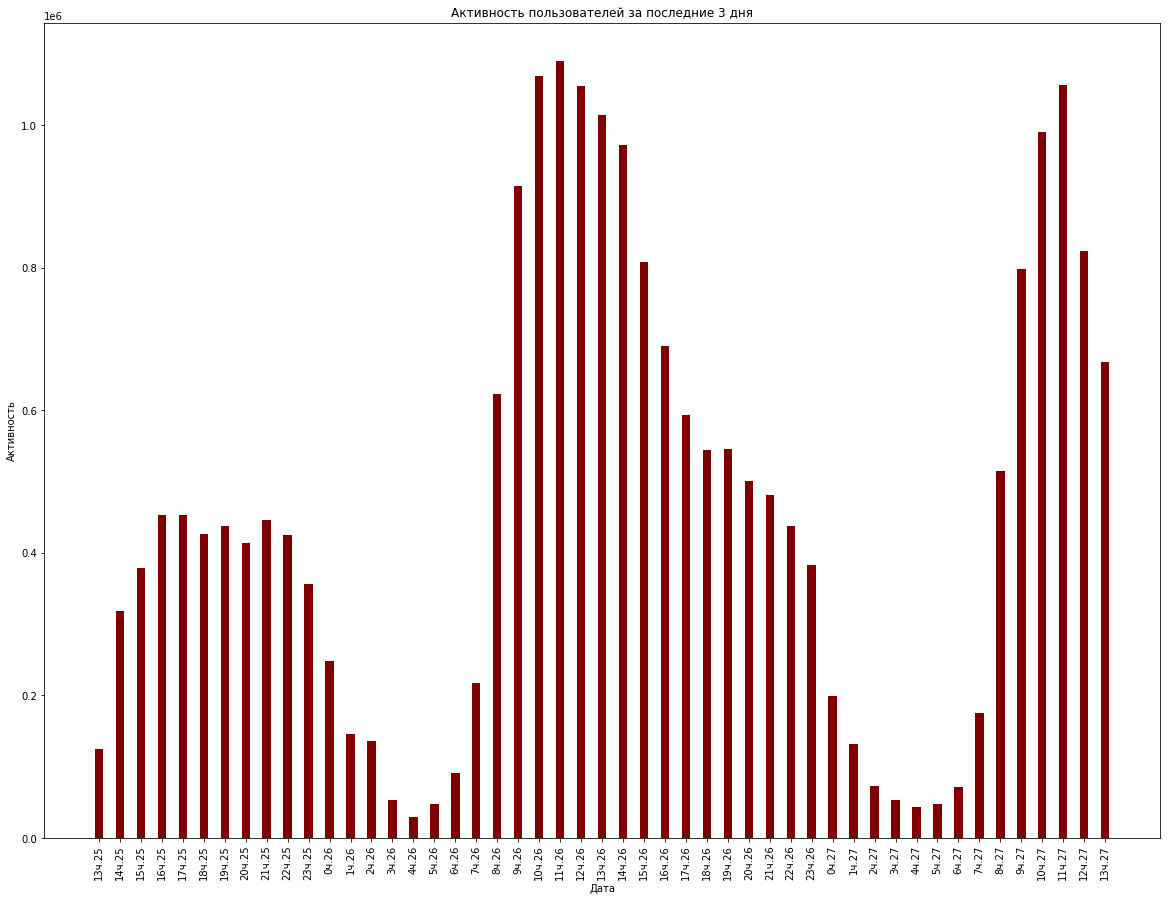

In [132]:
start_time = perf_counter()
result = client.execute('select * from (SELECT toHour(time) AS hour, toDayOfMonth(time) AS day, count() FROM default.log where time>now()-2*24*60*60 and time is not null GROUP BY hour, day WITH ROLLUP order by day,hour) where day!=0;')
print("Активность пользователей за последние 3 дня")
array_x = []
array_y = []
for res in result:
    print(f"{res[0]} ч. {res[1]} д. - {res[2]}")
    array_x.append(f"{res[0]}ч.{res[1]}")
    array_y.append(res[2])

fig = plt.figure(figsize = (20, 15))
plt.bar(array_x, array_y, color ='maroon', width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Дата")
plt.ylabel("Активность")
plt.title("Активность пользователей за последние 3 дня")
plt.show()